## Investing factors influencing route choice from Connected Car Data

                                                 Clustering

In [45]:
#Scikit Mobility Library
import skmob
from skmob import preprocessing
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import compression

#Datashader Library
#import datashader as ds, pandas as pd, colorcet as cc
# from datashader import transfer_functions as tf
# from datashader.colors import Hot
# from datashader.utils import export_image

#Dask & Flask_sqlalchemy libraries
# import dask
# import sqlalchemy


#Other ancillary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn; seaborn.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
import geopandas as gpd
import pyarrow
import pyodbc
import webbrowser
import glob
import os
import osmnx as ox
from shapely.geometry import LineString, Point


import warnings
warnings.filterwarnings('ignore')

Reading In Data

In [1]:
uk1 = pd.read_parquet(r"N:\Code Routing Behaviour\Ukmaindata1.parquet")
uk1.tail()

### Filetering Dataframe

##### Equal Number of Days represented in dataframe. 

Selecting values based on date from 4th July to 30th July that way we have an equal number of represented days to analyse.

In [47]:
mask = (uk1['datetime'] >= '2022-07-04') & (uk1['datetime'] < '2022-08-01')

In [48]:
df = uk1[mask]

##### Filetering Out Oneway Trips

Round trips distort Sinuosity values

In [49]:
Main = df.loc[df["shortestPath_dist"]>=0.8].copy()

In [50]:
Main.shape

(1225270, 13)

In [2]:
df2 =Main.copy().set_index('tid')
df2.head()

# Clustering - Identifying trips with similar characteristics 

- Select features based on Correlation, exclude highly correlated variables 

- Determine optimum number of clusters using silhouette Score or elbow method

- plot cluster centriods to understand what clusters tell us about the data

In [54]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm

Excluding (travel time, shortest distance, cumulative_ang_dev, avg_speed) features due to high correlation

In [60]:
X = df2[['distance_straight_line','num_of_turns','sinuosity']].copy()

Variance Inflation Factor measures the extent to which the variables are highly correlated with each other. Informs on which variable inform clusters.

- A VIF value of 1 indaces no correlation

- A VIF value >= 5 indicates high levels of correlation and should be removed from model 

In [61]:
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

for i in range(len(vif)):
    print(f"Feature {i+1}: VIF= {vif[i]: .2f}")

Feature 1: VIF=  1.54
Feature 2: VIF=  2.25
Feature 3: VIF=  1.68


Sample of data to form clusters on. 

#### Standardise data (Z-scores)

In [56]:
scaler = StandardScaler()
scaler.fit(X)
scaled = scaler.transform(X)
scaled

array([[ 0.43723542,  1.3166678 , -0.02026491,  0.76445014],
       [ 4.20590028, -0.47203783, -0.25544857, -0.24935884],
       [ 0.04280372, -0.33954112, -0.14719022, -0.19196585],
       ...,
       [-0.35222466, -0.47203783, -0.12713565, -0.6000272 ],
       [-0.43845595, -0.47203783, -0.22329334, -0.1090103 ],
       [-0.22718677, -0.60453454, -0.30915295, -0.6000272 ]])

### Number of clusters - Identify using silhouette score.

A silhouette score is a measure of how similar an object is to its cluster. It ranges from -1 to 1, where 1 indicates the best match of an object to its cluster and -1 shows an object is best match to a different cluster.

In determining K = The silhouette score with the highest average points to the cluster number suitable.

In [12]:
%%time

P = scaled

# Define silhouette_scores function which takes standardized data and range of clusters
def silhouette_scores(P,cluster_range):

     print('clusters:',n_clusters)

#Fit the KMeans model wit hthe specified number of clusters
     kmeans = KMeans(n_clusters = n_clusters, random_state=100)

     kmeans.fit(P)

     print('fit:',kmeans)

# Get the labes for each sample in dataset
     labels = kmeans.labels_

# Calculate the silhouette score for the clustering solution
     silh_avg = metrics.silhouette_score(P, labels)

     print('Cluster Label:',labels)

     return silh_avg

     davies_bouldin_score(X,labels)

CPU times: total: 0 ns
Wall time: 0 ns


In [121]:
#Define a list to store the silhouette scores
scores = []   

#Loop through range of cluster values 
for n_clusters in tqdm(range(2,7)):
    score = silhouette_scores(P, n_clusters)
    scores.append(score)
    
#Print the average silhouette score for each number of clusters
print("Number of clusters, Average Silhouette Score")
for n_clusters, score in zip(range(2,7), scores):
    print(f"clusters: {score:.4f}")

  0%|                                                       | 0/6 [00:00<?, ?it/s]

clusters: 2
fit: KMeans(n_clusters=2, random_state=100)


 17%|██████▌                                | 1/6 [4:26:18<22:11:31, 15978.40s/it]

Cluster Label: [1 0 1 ... 1 1 1]
clusters: 3
fit: KMeans(n_clusters=3, random_state=100)


 33%|█████████████                          | 2/6 [8:51:20<17:42:15, 15933.80s/it]

Cluster Label: [2 2 0 ... 0 0 0]
clusters: 4
fit: KMeans(n_clusters=4, random_state=100)


 50%|███████████████████                   | 3/6 [13:07:13<13:03:24, 15668.15s/it]

Cluster Label: [1 2 0 ... 0 0 0]
clusters: 5
fit: KMeans(n_clusters=5, random_state=100)


 67%|██████████████████████████             | 4/6 [17:24:19<8:39:05, 15572.74s/it]

Cluster Label: [0 3 1 ... 1 1 1]
clusters: 6
fit: KMeans(n_clusters=6, random_state=100)


 83%|████████████████████████████████▌      | 5/6 [21:33:50<4:15:55, 15355.81s/it]

Cluster Label: [4 2 3 ... 3 3 3]
clusters: 7
fit: KMeans(n_clusters=7, random_state=100)


100%|█████████████████████████████████████████| 6/6 [25:40:06<00:00, 15401.09s/it]

Cluster Label: [1 4 6 ... 6 6 6]
Number of clusters, Average Silhouette Score
clusters: 0.6950
clusters: 0.6784
clusters: 0.5535
clusters: 0.5445
clusters: 0.4486
clusters: 0.4523


it took 60:59:54<00:00 to obtain silh score of entire dataset

In [13]:
#Filtered Dataset
scores = [0.695042296205592, 0.6783916229946069, 0.5534539836239352, 0.5444909653625511, 0.44858804118886814, 0.45226959468556305]

In [14]:
#Full Dataset
scores1 = [0.7116610421570926, 0.6990613076110682, 0.5645334317540861, 0.5150178913313953, 0.5128716213367801, 0.4501447905611418, 0.4401899582341886, 0.44091482671860915]

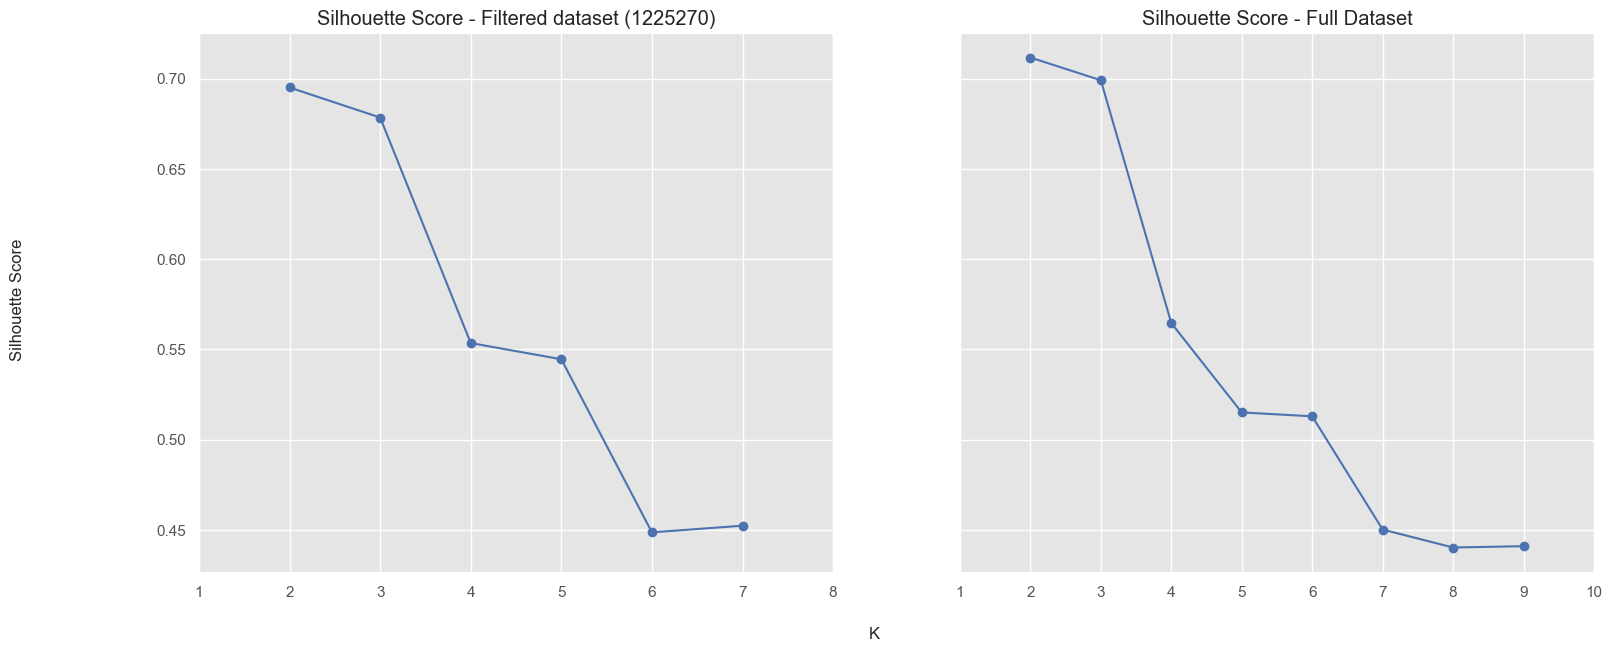

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=True) 
fig.set_size_inches(18,7)

ax1.plot(range(2,8), scores , 'bo-')
ax1.set_title('Silhouette Score - Filtered dataset (1225270)', loc='center')
ax1.set_xlim(1,8)

ax2.plot(range(2,10), scores1 , 'bo-')
ax2.set_title('Silhouette Score - Full Dataset')
ax2.set_xlim(1,10)

fig.supxlabel("K") 
fig.supylabel("Silhouette Score")
plt.show()

### Number of clusters - Identify using YellowBricks.

Yellowbrick SilhouetteVisualizer helps show how close points in a cluster is to its neighbour. Silhouette coefficients close to 1 show points in one cluster are far from its neighbour. 

Coeffiecients close to 0 indicate points are close to its neighbouring cluster

Negative coefficients show point might be assigned to a wrong cluster. 

*When Clusters have an coefficient below the average score it means that number of cluseters is a bad fit. Ideally the chosen number of clusters applied to a dataset should have all cluster coefficients above its average*

In [16]:
from yellowbrick.cluster import SilhouetteVisualizer

In [63]:
range_n_clusters = [2,3,4,5,6,7]

##### Test 8 clusters 

In [52]:
model = KMeans(8,random_state=100)
k_values = range(2,10)

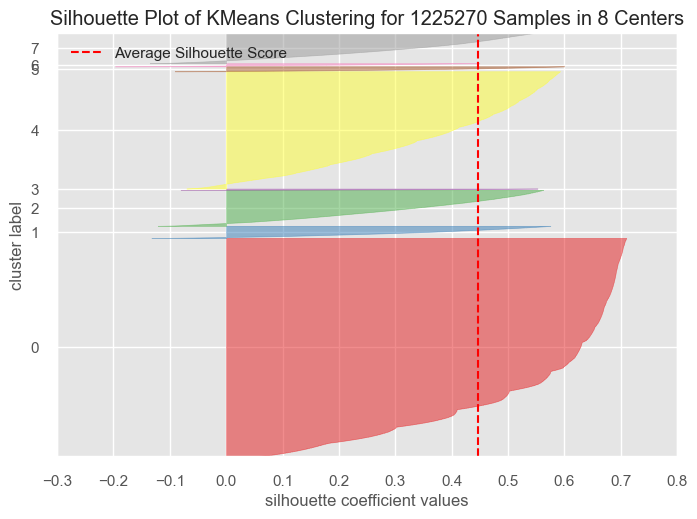

CPU times: total: 13h 37min 3s
Wall time: 7h 54min 37s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1225270 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [125]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model, k=k_values, metric='euclidean', random_state=100)
silhouette_visualizer.fit(X)
silhouette_visualizer.poof()

##### Looking at 6 clusters

In [126]:
model6 = KMeans(6,random_state=100)

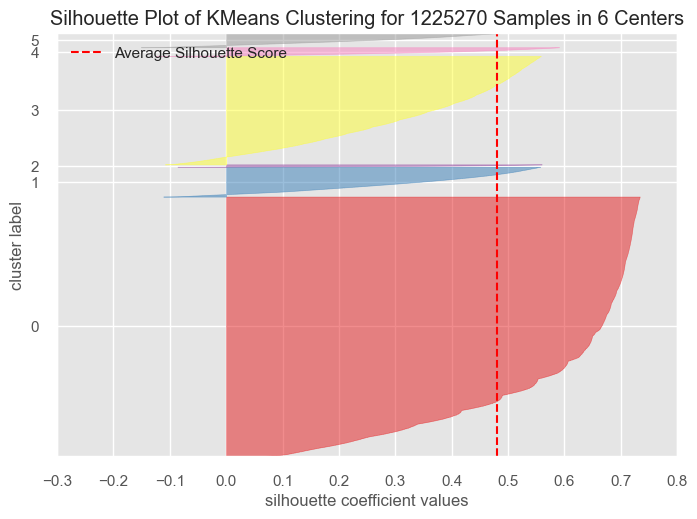

CPU times: total: 13h 50min 39s
Wall time: 8h 8min 32s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1225270 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [127]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model6, metric='euclidean', random_state=100)
silhouette_visualizer.fit(X)
silhouette_visualizer.poof()

##### Looking at 5 clusters

In [128]:
model5 = KMeans(5,random_state=100)

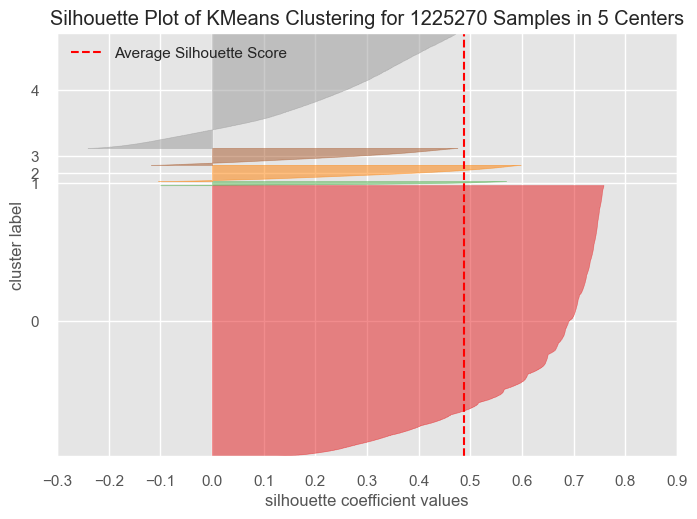

CPU times: total: 13h 57min 22s
Wall time: 8h 14min 21s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1225270 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [129]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model5, metric='euclidean', random_state=100)
silhouette_visualizer.fit(X)
silhouette_visualizer.poof()

##### Looking at 4 clusters

In [130]:
model2 = KMeans(4,random_state=100)

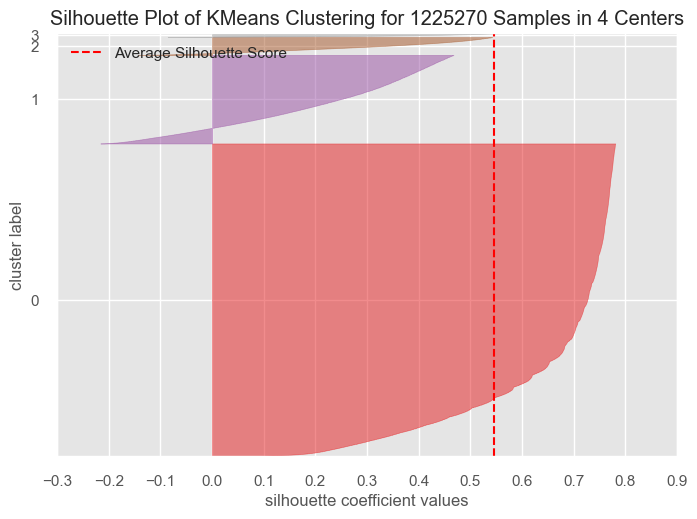

CPU times: total: 14h 16min 47s
Wall time: 8h 32min 37s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1225270 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [131]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model2, metric='euclidean', random_state=100)
silhouette_visualizer.fit(X)
silhouette_visualizer.poof()

##### Looking at 3 clusters

In [132]:
model3 = KMeans(3,random_state=100)

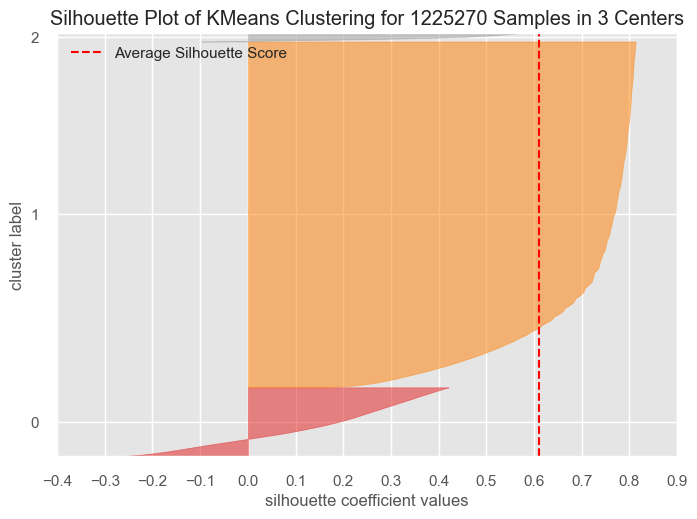

CPU times: total: 14h 29min 53s
Wall time: 8h 45min 43s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1225270 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [133]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model3, metric='euclidean', random_state=100)
silhouette_visualizer.fit(X)
silhouette_visualizer.poof()

##### Looking at 2 clusters

In [134]:
model4 = KMeans(2,random_state=100)

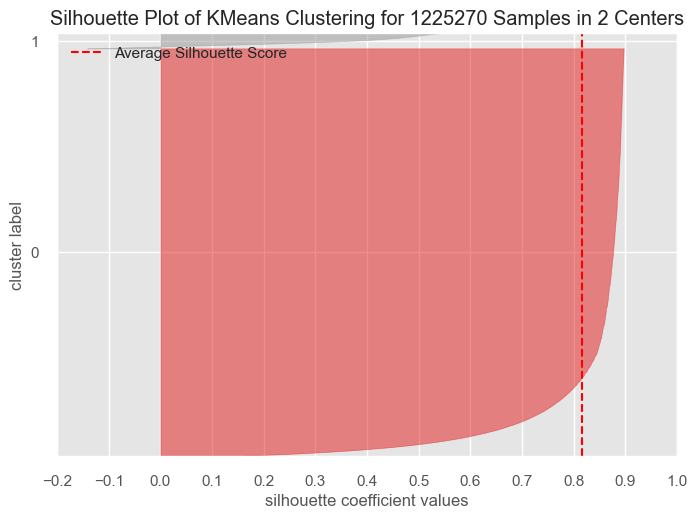

CPU times: total: 14h 55min 40s
Wall time: 9h 9min 52s


<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 1225270 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [135]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model4, metric='euclidean', random_state=100)
silhouette_visualizer.fit(X)
silhouette_visualizer.poof()

#### Number of clusters to be used in Kmeans ML Clusters is 2

In [147]:
Main2 = pd.read_parquet("N:\Code Routing Behaviour\Clusters\ReClust2Ukmain.parquet")

In [140]:
#kmeans = KMeans(n_clusters = 2).fit(P)

In [141]:
#labels = kmeans.labels_

In [142]:
#Main['clusters'] = labels

In [148]:
Clust_mean = Main2.set_index(['tid']).groupby('clusters').mean()
Clust_mean

,distance_straight_line,Traveltime,StopTime,num_of_turns,abs_bearing_change,shortestPath_dist,speed,sinuosity
clusters,,,,,,,,
0,8.0852,12.0763,3.4125,14.1266,2067.9479,5.8273,37.6338,1.5037
1,63.6016,63.1589,17.7032,47.2777,6892.0920,45.4840,55.5857,2.4817


#### Number of clusters to be used in Kmeans ML Clusters is 3. 

In [194]:
Main3 = pd.read_parquet("N:\Code Routing Behaviour\ReClust3Ukmain.parquet")

In [153]:
#kmeans = KMeans(n_clusters = 3).fit(P)

In [154]:
#labels = kmeans.labels_

In [155]:
#Main['clusters'] = labels

In [156]:
Clust_mean = Main3.set_index(['tid']).groupby('clusters').mean()
Clust_mean

,distance_straight_line,Traveltime,StopTime,num_of_turns,abs_bearing_change,shortestPath_dist,speed,sinuosity
clusters,,,,,,,,
0,61.9162,61.3964,17.0724,46.0826,6714.7950,44.9660,55.6264,1.8826
1,7.8972,11.8914,3.3644,13.9848,2047.8289,5.6725,37.5195,1.5147
2,47.4582,69.6399,26.2937,68.4134,9874.4582,1.6314,45.2120,30.7414


#### Number of clusters to be used in Kmeans ML Clusters is 4. 

In [5]:
Main4 = pd.read_parquet("N:\Code Routing Behaviour\Clusters\Clust4Ukmaindata.parquet")

In [3]:
#kmeans = KMeans(n_clusters = 4).fit(P)

In [19]:
#labels = kmeans.labels_

In [20]:
#Main['clusters'] = labels

In [21]:
Clust_mean = Main4.set_index(['tid']).groupby('clusters').mean()
Clust_mean

,distance_straight_line,Traveltime,StopTime,num_of_turns,abs_bearing_change,shortestPath_dist,speed,sinuosity
clusters,,,,,,,,
0,6.980640,10.241685,2.698902,11.445972,1752.152275,5.124375,37.706195,1.464187
1,22.451064,31.744489,10.615094,37.198762,4929.063701,15.141811,40.481536,1.931909
2,139.104767,107.173188,22.730845,42.169684,7643.359527,106.000552,80.398519,1.399268
3,48.741020,71.389372,26.940270,70.130695,10124.037652,1.629142,45.488677,31.667631


                               Temporal Analysis and Clusters - 4 Clusters being Used

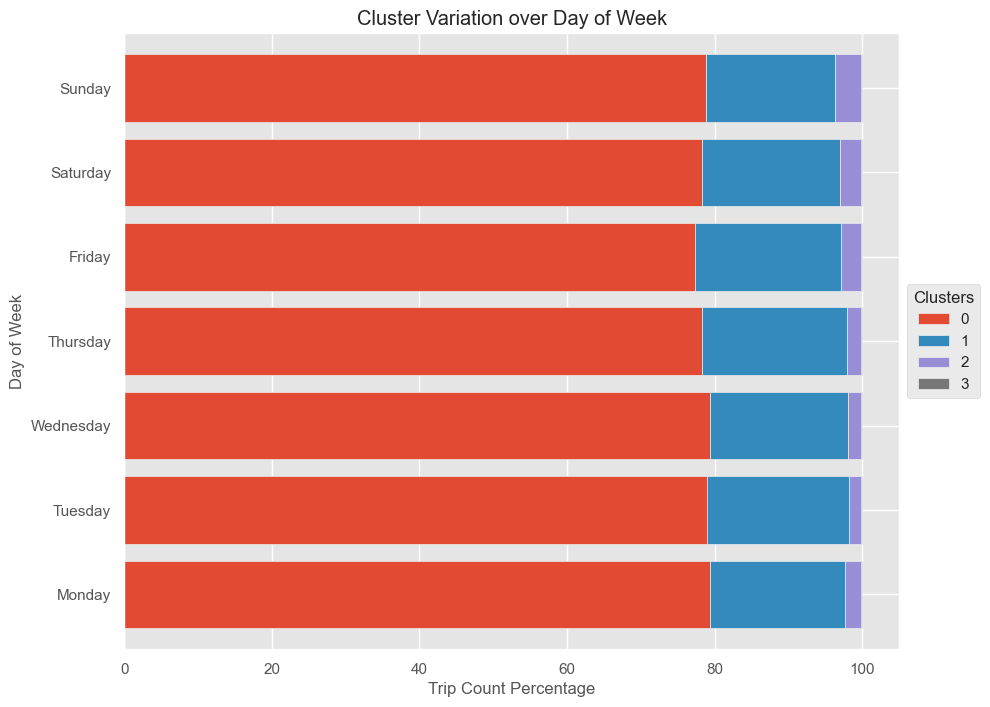

In [11]:
#group data by day of week and cluster label
group_dfh = Main4.groupby(['weekday','clusters']).size().reset_index(name='count').copy()

#Create pivot tabel for stacked bar plot
piv_dfh = group_dfh.pivot(index='weekday', columns='clusters', values='count')
piv_dfh = piv_dfh.apply(lambda x: x/ x.sum() * 100, axis=1)


#Plot stacked bar chart
ax = piv_dfh.plot(kind='barh', stacked=True, width=0.8, figsize=(10,8))
ax.set_title('Cluster Variation over Day of Week')
ax.set_xlabel('Trip Count Percentage')
ax.set_ylabel('Day of Week')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Clusters') 

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clustered_Trip_perDay.png", dpi=300, bbox_inches='tight')

plt.show()

Hour of day

In [12]:
group_dfh = Main4.groupby(['hour','clusters']).size().reset_index(name='count')

In [13]:
pivot_dfh = group_dfh.pivot(index='hour', columns='clusters', values='count')

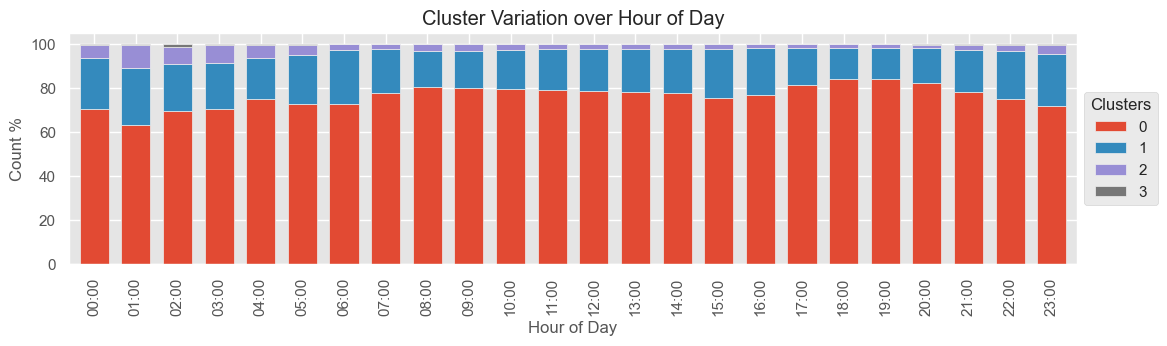

In [14]:
piv_d = pivot_dfh.apply(lambda x: x/ x.sum() * 100, axis = 1)
piv_d.plot(kind='bar', stacked=True, figsize=(13,3), width=0.7)

plt.title('Cluster Variation over Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count %')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Clusters')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clustered_Trip_perHour.png", dpi=300, bbox_inches='tight')

plt.show()

#### Cluster 0 

In [15]:
clust0 = Main4.loc[Main4['clusters'] == 0 ]
cf2 = clust0.copy()

In [16]:
cf2.shape

(962822, 15)

In [17]:
Trange = cf2.loc[(cf2['hour'] >= '06:00') & (cf2['hour'] <= '20:00')]

In [18]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
Trange['weekday'] = pd.Categorical(Trange['weekday'], 
                                categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

Average Distance Travelled 

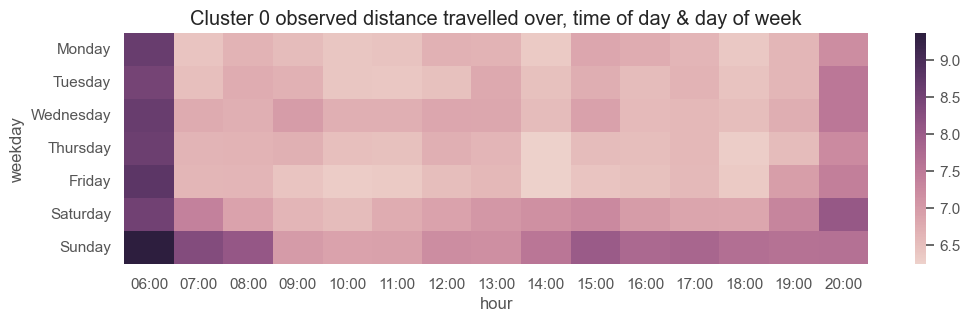

In [19]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange.pivot_table(index="weekday",columns="hour",values="distance_straight_line",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 0 observed distance travelled over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Cluster0_dist_day&time.png", dpi=300, bbox_inches='tight')

plt.show()

Average number of turns taken

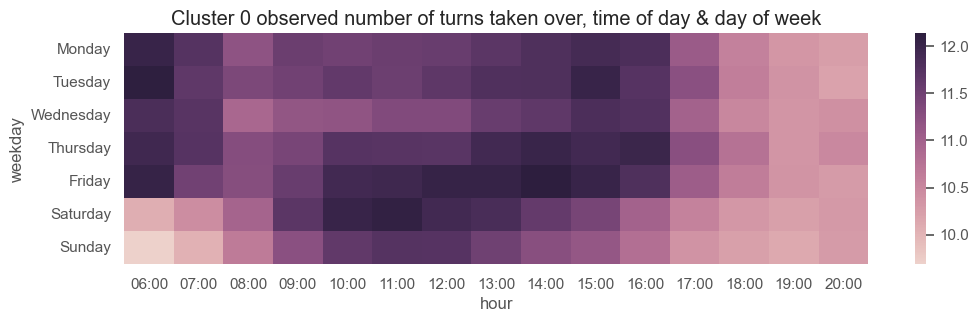

In [22]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange.pivot_table(index="weekday",columns="hour",values="num_of_turns",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 0 observed number of turns taken over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clustered0_turns_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

Sinuocity

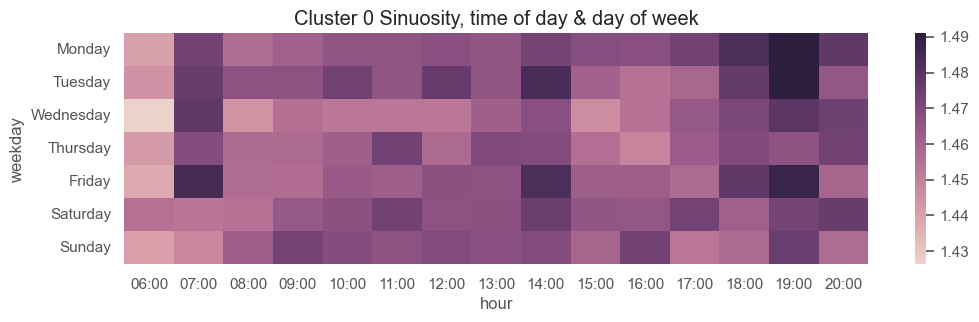

In [23]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange.pivot_table(index="weekday",columns="hour",values="sinuosity",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 0 Sinuosity, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Cluster0_Sinu_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

#### Cluster 1 

In [25]:
clust1 = Main4.loc[Main4['clusters'] == 1 ]
cf3 = clust1.copy()

In [26]:
Trange1 = cf3.loc[(cf3['hour'] >= '06:00') & (cf3['hour'] <= '20:00')]

In [27]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
Trange1['weekday'] = pd.Categorical(Trange1['weekday'], 
                                categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

Average Distance Travelled 

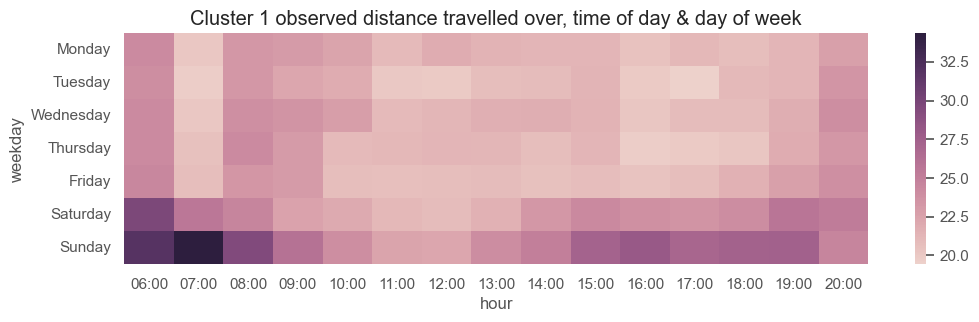

In [28]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange1.pivot_table(index="weekday",columns="hour",values="distance_straight_line",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 1 observed distance travelled over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Cluster1_dist_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

Average Number of Turns

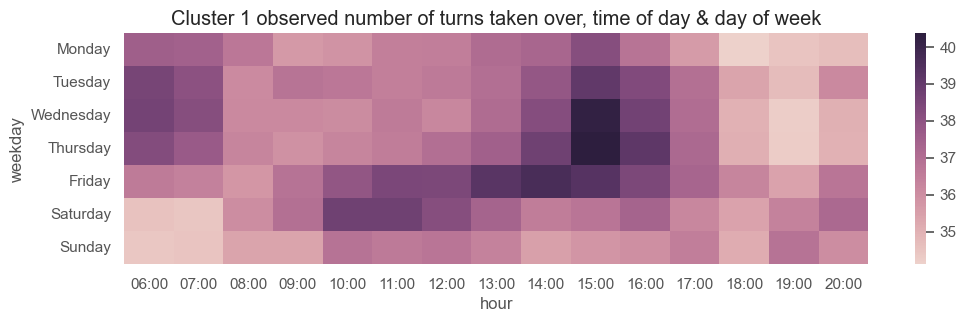

In [29]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange1.pivot_table(index="weekday",columns="hour",values="num_of_turns",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 1 observed number of turns taken over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Cluster1_Turns_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

Sinuosity

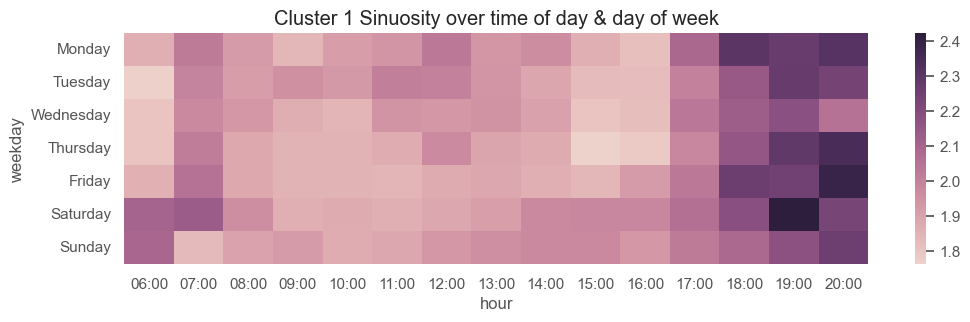

In [30]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange1.pivot_table(index="weekday",columns="hour",values="sinuosity",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 1 Sinuosity over time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Cluster1_Sinu_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

#### Cluster 2 

In [31]:
clust2 = Main4.loc[Main4['clusters'] == 2 ]
cf4 = clust2.copy()

In [32]:
cf4.shape

(29166, 15)

In [33]:
Trange2 = cf4.loc[(cf4['hour'] >= '06:00') & (cf4['hour'] <= '20:00')]

In [34]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
Trange2['weekday'] = pd.Categorical(Trange2['weekday'], 
                                categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

Average Distance Travelled 

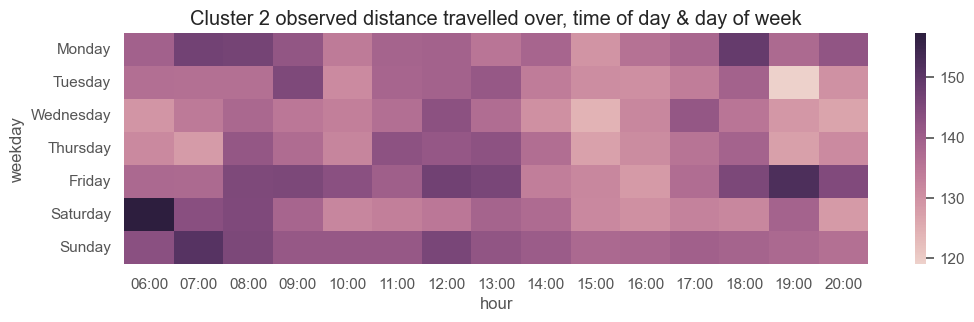

In [35]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange2.pivot_table(index="weekday",columns="hour",values="distance_straight_line",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 2 observed distance travelled over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clust2_dist_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

Average Number of turns

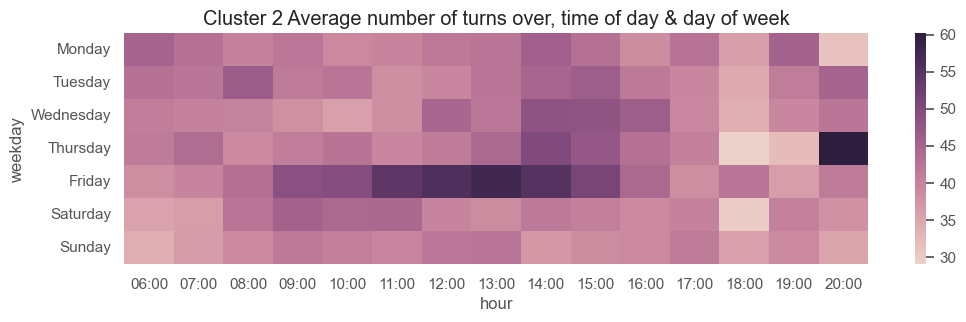

In [36]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange2.pivot_table(index="weekday",columns="hour",values="num_of_turns",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 2 Average number of turns over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clust2_Turns_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

Sinuosity

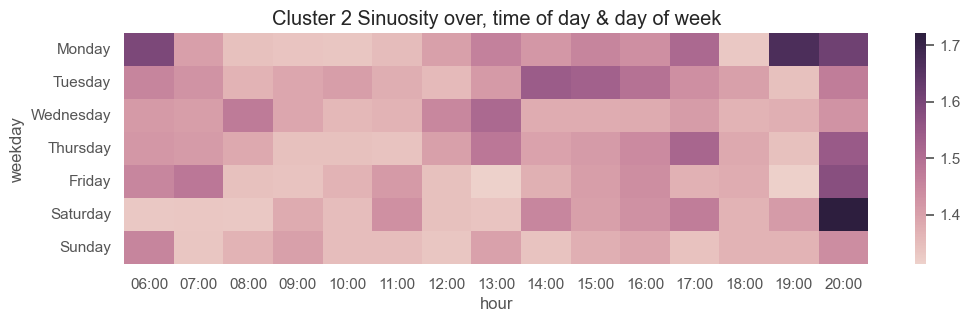

In [37]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange2.pivot_table(index="weekday",columns="hour",values="sinuosity",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 2 Sinuosity over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clust2_Sinu_pertime&Day.png", dpi=300, bbox_inches='tight')

plt.show()

#### Cluster 3 

In [38]:
clust3 = Main4.loc[Main4['clusters'] == 3 ]
cf5 = clust3.copy()

In [39]:
cf5.shape

(1668, 15)

In [40]:
Trange3 = cf5.loc[(cf5['hour'] >= '06:00') & (cf5['hour'] <= '20:00')]

In [41]:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
Trange3['weekday'] = pd.Categorical(Trange3['weekday'], 
                                categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)

Average Distance Travelled 

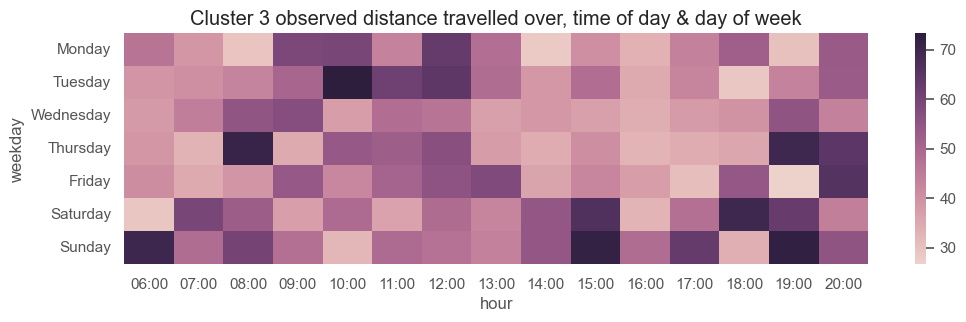

In [42]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange3.pivot_table(index="weekday",columns="hour",values="distance_straight_line",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 3 observed distance travelled over, time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clust3_dist_perDay.png", dpi=300, bbox_inches='tight')

plt.show()

Average Number of Turns 

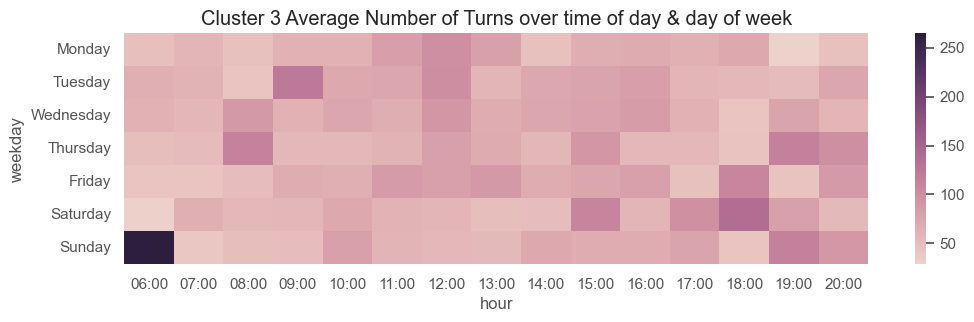

In [43]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange3.pivot_table(index="weekday",columns="hour",values="num_of_turns",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 3 Average Number of Turns over time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Clust3_Turns_perDay.png", dpi=300, bbox_inches='tight')

plt.show()

Sinuosity

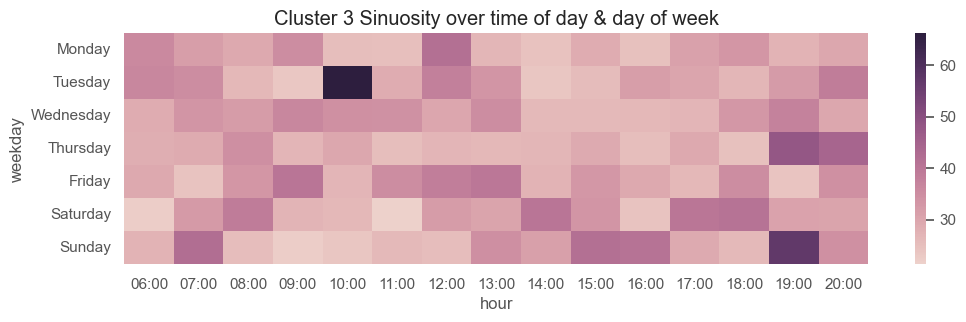

In [44]:
fig, ax = plt.subplots(1, figsize=(12,3))

sns.heatmap(Trange3.pivot_table(index="weekday",columns="hour",values="sinuosity",aggfunc="mean"), 
            cmap=sns.cubehelix_palette(as_cmap=True),
            xticklabels = (['06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00']),
            )  
plt.title('Cluster 3 Sinuosity over time of day & day of week')

plt.savefig(r"N:\Output\Full Dataset\Clustering\4 Cluster Centers\Stats\Cluster3_Sinu_perDay.png", dpi=300, bbox_inches='tight')

plt.show()

### Re-clustering on Large Cluster

                                                    Cluster - 0

In [187]:
cf2.head(2)

,tid,origin,dest,distance_straight_line,datetime,Traveltime,StopTime,num_of_turns,abs_bearing_change,shortestPath_dist,speed,sinuosity,weekday,hour,clusters
171586,171587,"[52.466662, -1.722651]","[52.543396, -1.633033]",14.1726,2022-07-04 00:02:54.877,14.1505,3.1998,12,1892.3900,10.4688,64.1287,1.3538,Monday,00:00,0
171587,171588,"[53.820921, -1.761847]","[53.845852, -1.737422]",4.7053,2022-07-04 00:03:27.397,9.6000,0.0000,19,2045.9700,3.2022,29.5097,1.4694,Monday,00:00,0


In [62]:
W = cf2[['distance_straight_line','num_of_turns','sinuosity']].copy()

Variance Inflation Factor measures the extent to which the variables are highly correlated with each other. Informs on which variable inform clusters.

- A VIF value of 1 indaces no correlation

- A VIF value >= 5 indicates high levels of correlation and should be removed from model 

In [63]:
vif = [variance_inflation_factor(W, i) for i in range(W.shape[1])]

for i in range(len(vif)):
    print(f"Feature {i+1}: VIF= {vif[i]: .2f}")

Feature 1: VIF=  1.75
Feature 2: VIF=  4.39
Feature 3: VIF=  4.11


Sample of data to form clusters on. 

#### Standardise data (Z-scores)

In [64]:
scaler = StandardScaler()
scaler.fit(W)
scaledA = scaler.transform(W)
scaledA

array([[ 0.89617133,  0.08889551, -0.25284779],
       [-0.28352269,  1.21206796,  0.01194603],
       [-0.27764919, -0.55291732,  0.04741325],
       ...,
       [-0.32936605, -0.2320109 , -0.17845376],
       [-0.59689029, -0.2320109 , -0.5351584 ],
       [ 0.05855192, -0.55291732, -0.85366146]])

In [65]:
%%time

Q = scaledA

# Define silhouette_scores function which takes standardized data and range of clusters
def silhouette_scores(Q,cluster_range):

     print('clusters:',n_clusters)

#Fit the KMeans model wit hthe specified number of clusters
     kmeans = KMeans(n_clusters = n_clusters, random_state=100)

     kmeans.fit(Q)

     print('fit:',kmeans)

# Get the labes for each sample in dataset
     labels = kmeans.labels_

# Calculate the silhouette score for the clustering solution
     silh_avg1 = metrics.silhouette_score(Q, labels)

     print('Cluster Label:',labels)

     return silh_avg1

CPU times: total: 0 ns
Wall time: 0 ns


In [66]:
#Define a list to store the silhouette scores
scores2 = []   

#Loop through range of cluster values 
for n_clusters in tqdm(range(2,8)):
    score1 = silhouette_scores(Q, n_clusters)
    scores2.append(score1)
    
#Print the average silhouette score for each number of clusters
print("Number of clusters, Average Silhouette Score")
for n_clusters, score1 in zip(range(2,8), scores2):
    print(f"clusters: {score1:.4f}")

  0%|                                                                          | 0/6 [00:00<?, ?it/s]

clusters: 2
fit: KMeans(n_clusters=2, random_state=100)


 17%|█████████▋                                                | 1/6 [3:50:25<19:12:09, 13825.81s/it]

Cluster Label: [0 0 1 ... 1 1 1]
clusters: 3
fit: KMeans(n_clusters=3, random_state=100)


 33%|███████████████████▎                                      | 2/6 [7:38:29<15:16:07, 13741.99s/it]

Cluster Label: [1 1 0 ... 0 0 0]
clusters: 4
fit: KMeans(n_clusters=4, random_state=100)


 50%|████████████████████████████▌                            | 3/6 [11:17:46<11:13:45, 13475.09s/it]

Cluster Label: [1 1 2 ... 2 2 2]
clusters: 5
fit: KMeans(n_clusters=5, random_state=100)


 67%|██████████████████████████████████████▋                   | 4/6 [14:55:02<7:23:23, 13301.53s/it]

Cluster Label: [1 1 0 ... 0 0 0]
clusters: 6
fit: KMeans(n_clusters=6, random_state=100)


 83%|████████████████████████████████████████████████▎         | 5/6 [18:26:21<3:37:57, 13077.12s/it]

Cluster Label: [2 1 2 ... 2 2 0]
clusters: 7
fit: KMeans(n_clusters=7, random_state=100)


100%|████████████████████████████████████████████████████████████| 6/6 [21:56:55<00:00, 13169.17s/it]

Cluster Label: [6 0 5 ... 5 5 2]
Number of clusters, Average Silhouette Score
clusters: 0.3474
clusters: 0.3712
clusters: 0.3914
clusters: 0.3782
clusters: 0.3073
clusters: 0.3145


In [67]:
scores3 = [0.3474, 0.3712,0.3914,0.3782, 0.3073, 0.3145]

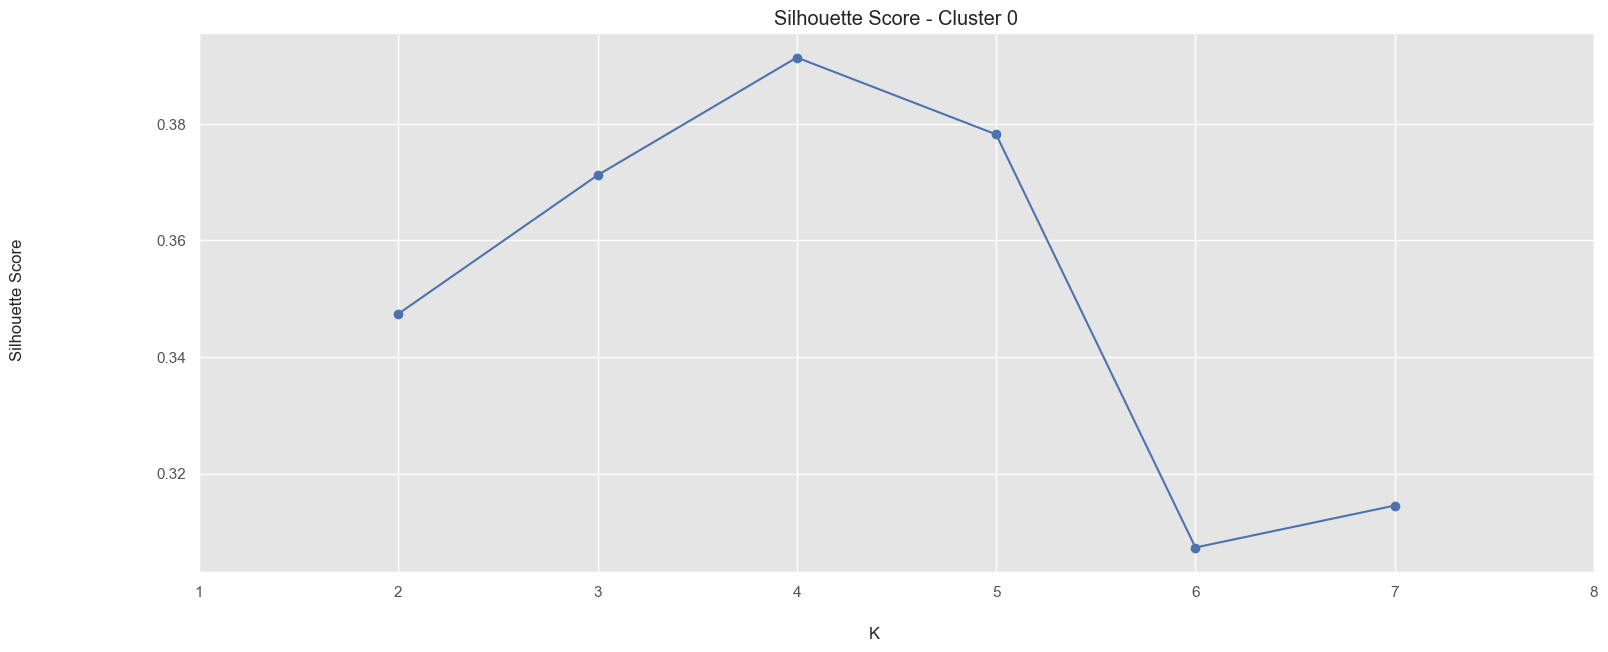

In [68]:
fig, ax = plt.subplots(1, figsize=(18,7)) 

ax.plot(range(2,8), scores3 , 'bo-')
ax.set_title('Silhouette Score - Cluster 0', loc='center')
ax.set_xlim(1,8)

fig.supxlabel("K") 
fig.supylabel("Silhouette Score")
plt.show()

#### Number of clusters to be used in Kmeans ML Clusters0, 3 clusters

In [81]:
kmeans = KMeans(n_clusters = 3).fit(Q)

In [82]:
labels = kmeans.labels_

In [83]:
clust0['Cluster_L2'] = labels

In [84]:
clust0.to_parquet("N:\Code Routing Behaviour\Clusters\Cluster0_L2_3clust.parquet")

In [85]:
Main03 = pd.read_parquet("N:\Code Routing Behaviour\Clusters\Cluster0_L2_3clust.parquet")

In [86]:
Clust_mean = Main03.set_index(['tid']).groupby('Cluster_L2').mean()
Clust_mean

,distance_straight_line,Traveltime,StopTime,num_of_turns,abs_bearing_change,shortestPath_dist,speed,sinuosity,clusters
Cluster_L2,,,,,,,,,
0,6.358171,11.604533,3.554068,17.264207,2327.702282,4.190762,33.179810,1.675425,0.0
1,4.124128,6.615506,1.553560,7.040594,1168.548007,3.195827,36.894227,1.337088,0.0
2,27.895871,27.159267,6.142160,13.374824,2881.143455,21.541971,63.111641,1.325763,0.0


#### Number of clusters to be used in Kmeans ML Clusters0, 4 clusters

In [69]:
kmeans = KMeans(n_clusters = 4).fit(Q)

In [70]:
labels = kmeans.labels_

In [71]:
clust0['Cluster_L2'] = labels

In [72]:
clust0.to_parquet("N:\Code Routing Behaviour\Clusters\Cluster0_L2_4clust.parquet")

In [73]:
Main04 = pd.read_parquet("N:\Code Routing Behaviour\Clusters\Cluster0_L2_4clust.parquet")

In [94]:
Clust_mean = Main04.set_index(['tid']).groupby('Cluster_L2').mean()
Clust_mean['%Stoptime'] = (Clust_mean['StopTime']/Clust_mean['Traveltime']) * 100
Clust_mean[['distance_straight_line','num_of_turns','sinuosity','Traveltime','StopTime','%Stoptime']]

,distance_straight_line,num_of_turns,sinuosity,Traveltime,StopTime,%Stoptime
Cluster_L2,,,,,,
0,6.903456,17.657209,1.451726,12.166333,3.642337,29.937841
1,4.055768,6.808771,1.340064,6.475528,1.505245,23.245132
2,5.226432,13.258840,2.656419,9.662302,3.046707,31.531899
3,29.492215,12.986155,1.326724,28.125279,6.309342,22.432992


#### Number of clusters to be used in Kmeans ML Clusters0, 5 clusters

In [75]:
kmeans = KMeans(n_clusters = 5).fit(Q)

In [76]:
labels = kmeans.labels_

In [77]:
clust0['Cluster_L2'] = labels

In [78]:
clust0.to_parquet("N:\Code Routing Behaviour\Clusters\Cluster0_L2_5clust.parquet")

In [79]:
Main05 = pd.read_parquet("N:\Code Routing Behaviour\Clusters\Cluster0_L2_5clust.parquet")

In [80]:
Clust_mean = Main05.set_index(['tid']).groupby('Cluster_L2').mean()
Clust_mean

,distance_straight_line,Traveltime,StopTime,num_of_turns,abs_bearing_change,shortestPath_dist,speed,sinuosity,clusters
Cluster_L2,,,,,,,,,
0,4.506112,8.268398,2.358395,12.091151,1746.829581,2.287400,33.424036,1.987703,0.0
1,6.249665,11.600269,3.976603,14.338904,2140.778548,1.787766,34.788893,3.588407,0.0
2,29.851152,28.342845,6.343038,12.910701,2896.766911,23.048923,64.925584,1.327442,0.0
3,7.288900,12.678940,3.777060,18.101746,2440.834270,5.358809,34.268228,1.396071,0.0
4,4.097499,6.478322,1.508268,6.634626,1122.703411,3.239911,37.202415,1.293534,0.0


### Number of clusters - Identify using YellowBricks.

Yellowbrick SilhouetteVisualizer helps show how close points in a cluster is to its neighbour. Silhouette coefficients close to 1 show points in one cluster are far from its neighbour. 

Coeffiecients close to 0 indicate points are close to its neighbouring cluster

Negative coefficients show point might be assigned to a wrong cluster. 

*When Clusters have an coefficient below the average score it means that number of cluseters is a bad fit. Ideally the chosen number of clusters applied to a dataset should have all cluster coefficients above its average*

In [95]:
from yellowbrick.cluster import SilhouetteVisualizer

In [96]:
range_n_clusters = [3,4,5,6]

##### Test 3 clusters 

In [97]:
model = KMeans(3,random_state=100)
k_values = range_n_clusters

In [ ]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model, k=k_values, metric='euclidean', random_state=100)
silhouette_visualizer.fit(Q)
silhouette_visualizer.poof()

##### Looking at 4 clusters

In [ ]:
model6 = KMeans(4,random_state=100)

In [ ]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model6, metric='euclidean', random_state=100)
silhouette_visualizer.fit(Q)
silhouette_visualizer.poof()

##### Looking at 5 clusters

In [ ]:
model5 = KMeans(5,random_state=100)

In [ ]:
%%time
silhouette_visualizer = SilhouetteVisualizer(model5, metric='euclidean', random_state=100)
silhouette_visualizer.fit(Q)
silhouette_visualizer.poof()

                                                    SPLIT - New Notebook